In [158]:
import json
import pandas as pd
import numpy as np
import re
from sqlalchemy import create_engine


In [2]:
file_dir = r'C:\Users\clava\Movies-ETL'

In [3]:
f'{file_dir}filename'

'C:\\Users\\clava\\Movies-ETLfilename'

In [4]:
with open(f'{file_dir}/wikipedia-movies.json', mode='r') as file:
    wiki_movies_raw = json.load(file)

In [5]:
len(wiki_movies_raw)

7311

In [6]:
# First 5 records
wiki_movies_raw[:5]

[{'url': 'https://en.wikipedia.org/wiki/The_Adventures_of_Ford_Fairlane',
  'year': 1990,
  'imdb_link': 'https://www.imdb.com/title/tt0098987/',
  'title': 'The Adventures of Ford Fairlane',
  'Directed by': 'Renny Harlin',
  'Produced by': ['Steve Perry', 'Joel Silver'],
  'Screenplay by': ['David Arnott', 'James Cappe', 'Daniel Waters'],
  'Story by': ['David Arnott', 'James Cappe'],
  'Based on': ['Characters', 'by Rex Weiner'],
  'Starring': ['Andrew Dice Clay',
   'Wayne Newton',
   'Priscilla Presley',
   'Lauren Holly',
   'Morris Day',
   'Robert Englund',
   "Ed O'Neill"],
  'Narrated by': 'Andrew "Dice" Clay',
  'Music by': ['Cliff Eidelman', 'Yello'],
  'Cinematography': 'Oliver Wood',
  'Edited by': 'Michael Tronick',
  'Productioncompany ': 'Silver Pictures',
  'Distributed by': '20th Century Fox',
  'Release date': ['July 11, 1990', '(', '1990-07-11', ')'],
  'Running time': '102 minutes',
  'Country': 'United States',
  'Language': 'English',
  'Budget': '$20 million',


In [7]:
# Last 5 records
wiki_movies_raw[-5:]

[{'url': 'https://en.wikipedia.org/wiki/Holmes_%26_Watson',
  'year': 2018,
  'imdb_link': 'https://www.imdb.com/title/tt1255919/',
  'title': 'Holmes & Watson',
  'Directed by': 'Etan Cohen',
  'Produced by': ['Will Ferrell',
   'Adam McKay',
   'Jimmy Miller',
   'Clayton Townsend'],
  'Screenplay by': 'Etan Cohen',
  'Based on': ['Sherlock Holmes',
   'and',
   'Dr. Watson',
   'by',
   'Sir Arthur Conan Doyle'],
  'Starring': ['Will Ferrell',
   'John C. Reilly',
   'Rebecca Hall',
   'Rob Brydon',
   'Steve Coogan',
   'Ralph Fiennes'],
  'Music by': 'Mark Mothersbaugh',
  'Cinematography': 'Oliver Wood',
  'Edited by': 'Dean Zimmerman',
  'Productioncompanies ': ['Columbia Pictures',
   'Gary Sanchez Productions',
   'Mosaic Media Group',
   'Mimran Schur Pictures'],
  'Distributed by': 'Sony Pictures Releasing',
  'Release date': ['December 25, 2018',
   '(',
   '2018-12-25',
   ')',
   '(United States)'],
  'Running time': '90 minutes',
  'Country': 'United States',
  'Language

In [8]:
# Some records in the middle
wiki_movies_raw[3600:3605]

[{'url': 'https://en.wikipedia.org/wiki/Benji:_Off_the_Leash!',
  'year': 2004,
  'imdb_link': 'https://www.imdb.com/title/tt0315273/',
  'title': 'Benji: Off the Leash!',
  'Directed by': 'Joe Camp',
  'Written by': 'Joe Camp',
  'Starring': ['Benji', 'Nick Whitaker', 'Shaggy', 'Gypsy the Cockatoo'],
  'Music by': 'Antonio di Lorenzo',
  'Productioncompany ': 'Mulberry Square Productions',
  'Distributed by': 'Mulberry Square Productions',
  'Release date': ['March 26, 2004', '(', '2004-03-26', ')'],
  'Running time': '97 min',
  'Country': 'United States',
  'Language': 'English',
  'Box office': '$3,817,362'},
 {'url': 'https://en.wikipedia.org/wiki/The_Best_Thief_in_the_World',
  'year': 2004,
  'imdb_link': 'https://www.imdb.com/title/tt0389796/',
  'title': 'The Best Thief in the World',
  'Directed by': 'Jacob Kornbluth',
  'Produced by': ['Tim Perrell', 'Nicola Usborne'],
  'Written by': 'Jacob Kornbluth',
  'Starring': ['Marc Rozendaal',
   'Michael Silverman',
   'David Warsh

In [9]:
kaggle_metadata = pd.read_csv(f'{file_dir}\movies_metadata.csv', low_memory=False)
ratings = pd.read_csv(f'{file_dir}\\ratings.csv')

In [10]:
kaggle_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [11]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [12]:
kaggle_metadata.sample(n=5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
12208,False,NaN,0,"[{'id': 36, 'name': 'History'}, {'id': 18, 'na...",NaN,17460,tt0792966,fr,La faute à Fidel!,A 9-year-old girl weathers big changes in her ...,...,2006-11-29,0.0,99.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,NaN,Blame It on Fidel!,False,6.9,9.0
27366,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,94881,tt0038239,en,Week-End at the Waldorf,Anything can happen during a weekend at New Yo...,...,1945-10-04,0.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,FORTY-EIGHT EXPLOSIVE HOURS!,Week-End at the Waldorf,False,0.0,2.0
3468,False,NaN,160000,"[{'id': 18, 'name': 'Drama'}]",NaN,38925,tt0071772,en,The Lords of Flatbush,Directed by Martin Davidson and Stephen Verona...,...,1974-05-01,4000000.0,86.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,When was the last time someone gave you a hickey?,The Lords of Flatbush,False,5.7,18.0
10226,False,NaN,35000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 35, '...",http://disney.go.com/disneypictures/skyhigh/,11459,tt0405325,en,Sky High,Set in a world where superheroes are commonly ...,...,2005-07-29,86369815.0,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Saving The World... One Homework Assignment At...,Sky High,False,5.8,568.0
17602,False,NaN,0,[],NaN,324011,tt0111792,en,The Yearling,"In 1870s Florida, a rural family struggles to ...",...,1994-04-24,0.0,90.0,[],Released,NaN,The Yearling,False,5.3,3.0


In [13]:
ratings.sample(n=5)

,userId,movieId,rating,timestamp
22547592,234160,73266,3.0,1498947186
3053541,31870,3468,2.0,1059541638
18543977,192482,466,1.5,1149175955
10543359,108820,2,2.0,1081163806
5104918,52570,337,4.5,1481829562


In [24]:
wiki_movies_df = pd.DataFrame(wiki_movies_raw)
len(wiki_movies_df.columns)

193

In [15]:
wiki_movies_df.columns.tolist()

['url',
 'year',
 'imdb_link',
 'title',
 'Directed by',
 'Produced by',
 'Screenplay by',
 'Story by',
 'Based on',
 'Starring',
 'Narrated by',
 'Music by',
 'Cinematography',
 'Edited by',
 'Productioncompany ',
 'Distributed by',
 'Release date',
 'Running time',
 'Country',
 'Language',
 'Budget',
 'Box office',
 'Written by',
 'Genre',
 'Theme music composer',
 'Country of origin',
 'Original language(s)',
 'Producer(s)',
 'Editor(s)',
 'Production company(s)',
 'Original network',
 'Original release',
 'Productioncompanies ',
 'Executive producer(s)',
 'Production location(s)',
 'Distributor',
 'Picture format',
 'Audio format',
 'Voices of',
 'Followed by',
 'Composer(s)',
 'Created by',
 'Also known as',
 'Opening theme',
 'No. of episodes',
 'Preceded by',
 'Author',
 'Publisher',
 'Publication date',
 'Media type',
 'Pages',
 'ISBN',
 'OCLC',
 'LC Class',
 'Cover artist',
 'Series',
 'Set in',
 'Adaptation by',
 'Suggested by',
 'Biographical data',
 'Born',
 'Died',
 'Resti

In [25]:
wiki_movies = [movie for movie in wiki_movies_raw
               if ('Director' in movie or 'Directed by' in movie)
                   and 'imdb_link' in movie]
len(wiki_movies)

7080

In [26]:
wiki_movies_df = pd.DataFrame(wiki_movies)
len(wiki_movies_df.columns)

78

In [27]:
def clean_movie(movie):
    movie = dict(movie) #create a non-destructive copy
    return movie

In [28]:
wiki_movies_df[wiki_movies_df['Preceded by'].notnull()]['Preceded by']

186                                        Psycho III
495                             [Blind Faith, (1990)]
608        Revenge of the Nerds II: Nerds in Paradise
893                                         The Birds
1028                               Midnight Runaround
1076    Revenge of the Nerds III: The Next Generation
1203                                   The Shaggy Dog
1228                   The Computer Wore Tennis Shoes
1370                                  Problem Child 2
1517                                           Dallas
Name: Preceded by, dtype: object

In [29]:
sorted(wiki_movies_df.columns.tolist())

['Adaptation by',
 'Also known as',
 'Animation by',
 'Arabic',
 'Audio format',
 'Based on',
 'Box office',
 'Budget',
 'Camera setup',
 'Cantonese',
 'Chinese',
 'Cinematography',
 'Color process',
 'Composer(s)',
 'Country',
 'Country of origin',
 'Created by',
 'Directed by',
 'Director',
 'Distributed by',
 'Distributor',
 'Edited by',
 'Editor(s)',
 'Executive producer(s)',
 'Followed by',
 'French',
 'Genre',
 'Hangul',
 'Hebrew',
 'Hepburn',
 'Japanese',
 'Label',
 'Language',
 'Length',
 'Literally',
 'Mandarin',
 'McCune–Reischauer',
 'Music by',
 'Narrated by',
 'No. of episodes',
 'Opening theme',
 'Original language(s)',
 'Original network',
 'Original release',
 'Original title',
 'Picture format',
 'Polish',
 'Preceded by',
 'Produced by',
 'Producer',
 'Producer(s)',
 'Production company(s)',
 'Production location(s)',
 'Productioncompanies ',
 'Productioncompany ',
 'Recorded',
 'Release date',
 'Released',
 'Revised Romanization',
 'Romanized',
 'Running time',
 'Russ

In [30]:
wiki_movies_df["Simplified"].value_counts()


我们诞生在中国    1
东宫西宫       1
叶问3        1
长城         1
Name: Simplified, dtype: int64

In [31]:
def clean_movie(movie):
    movie = dict(movie) #create a non-destructive copy
    alt_titles = {}
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune–Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
    if len(alt_titles) > 0:
        movie['alt_titles'] = alt_titles
        
    # merge column names
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
    change_column_name('Adaptation by', 'Written by')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release date')
    change_column_name('Screen story by', 'Written by')
    change_column_name('Screenplay by', 'Written by')
    change_column_name('Story by', 'Written by')
    change_column_name('Theme music composer', 'Composer(s)')
    

    return movie

In [32]:
clean_movies = [clean_movie(movie) for movie in wiki_movies]
wiki_movies_df = pd.DataFrame(clean_movies)
sorted(wiki_movies_df.columns.tolist())

['Animation by',
 'Audio format',
 'Based on',
 'Box office',
 'Budget',
 'Camera setup',
 'Cinematography',
 'Color process',
 'Composer(s)',
 'Country',
 'Created by',
 'Director',
 'Distributor',
 'Editor(s)',
 'Executive producer(s)',
 'Followed by',
 'Genre',
 'Label',
 'Language',
 'Narrated by',
 'No. of episodes',
 'Opening theme',
 'Original language(s)',
 'Original network',
 'Picture format',
 'Preceded by',
 'Producer(s)',
 'Production company(s)',
 'Production location(s)',
 'Recorded',
 'Release date',
 'Running time',
 'Starring',
 'Suggested by',
 'Venue',
 'Voices of',
 'Written by',
 'alt_titles',
 'imdb_link',
 'title',
 'url',
 'year']

In [33]:
wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
print(len(wiki_movies_df))
wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
print(len(wiki_movies_df))
wiki_movies_df.head()

7080
7037


,url,year,imdb_link,title,Based on,Starring,Narrated by,Cinematography,Release date,Running time,...,alt_titles,Preceded by,Suggested by,Recorded,Venue,Label,Animation by,Color process,Camera setup,imdb_id
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...","Andrew ""Dice"" Clay",Oliver Wood,"[July 11, 1990, (, 1990-07-11, )]",102 minutes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt0098987
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",NaN,Mark Plummer,"[May 17, 1990, (, 1990-05-17, ), (Cannes Film ...",114 minutes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt0098994
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",NaN,Roger Deakins,"[August 10, 1990, (, 1990-08-10, )]",113 minutes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt0099005
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",NaN,Carlo Di Palma,"[December 25, 1990, (, 1990-12-25, )]",106 minutes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt0099012
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",NaN,Russell Boyd,"December 19, 1990",95 minutes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt0099018


In [34]:
wiki_movies_df.count()

url                       7037
year                      7037
imdb_link                 7037
title                     7036
Based on                  2182
Starring                  6852
Narrated by                282
Cinematography            6344
Release date              7005
Running time              6898
Country                   6801
Language                  6789
Budget                    4739
Box office                5485
Director                  7037
Distributor               6677
Editor(s)                 6489
Composer(s)               6518
Producer(s)               6834
Production company(s)     5359
Written by                6836
Genre                      114
Original language(s)       162
Original network           129
Executive producer(s)      100
Production location(s)      50
Picture format              68
Audio format                64
Voices of                    2
Followed by                  9
Created by                  11
Opening theme                1
No. of e

In [35]:
[[column,wiki_movies_df[column].isnull().sum()] for column in wiki_movies_df.columns]

[['url', 0],
 ['year', 0],
 ['imdb_link', 0],
 ['title', 1],
 ['Based on', 4855],
 ['Starring', 185],
 ['Narrated by', 6755],
 ['Cinematography', 693],
 ['Release date', 32],
 ['Running time', 139],
 ['Country', 236],
 ['Language', 248],
 ['Budget', 2298],
 ['Box office', 1552],
 ['Director', 0],
 ['Distributor', 360],
 ['Editor(s)', 548],
 ['Composer(s)', 519],
 ['Producer(s)', 203],
 ['Production company(s)', 1678],
 ['Written by', 201],
 ['Genre', 6923],
 ['Original language(s)', 6875],
 ['Original network', 6908],
 ['Executive producer(s)', 6937],
 ['Production location(s)', 6987],
 ['Picture format', 6969],
 ['Audio format', 6973],
 ['Voices of', 7035],
 ['Followed by', 7028],
 ['Created by', 7026],
 ['Opening theme', 7036],
 ['No. of episodes', 7033],
 ['alt_titles', 7015],
 ['Preceded by', 7027],
 ['Suggested by', 7036],
 ['Recorded', 7035],
 ['Venue', 7036],
 ['Label', 7035],
 ['Animation by', 7035],
 ['Color process', 7036],
 ['Camera setup', 7036],
 ['imdb_id', 0]]

In [36]:
[column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]

['url',
 'year',
 'imdb_link',
 'title',
 'Based on',
 'Starring',
 'Cinematography',
 'Release date',
 'Running time',
 'Country',
 'Language',
 'Budget',
 'Box office',
 'Director',
 'Distributor',
 'Editor(s)',
 'Composer(s)',
 'Producer(s)',
 'Production company(s)',
 'Written by',
 'imdb_id']

In [37]:
wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]
wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]

In [38]:
wiki_movies_df.head(5)

,url,year,imdb_link,title,Based on,Starring,Cinematography,Release date,Running time,Country,...,Budget,Box office,Director,Distributor,Editor(s),Composer(s),Producer(s),Production company(s),Written by,imdb_id
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,"[July 11, 1990, (, 1990-07-11, )]",102 minutes,United States,...,$20 million,$21.4 million,Renny Harlin,20th Century Fox,Michael Tronick,"[Cliff Eidelman, Yello]","[Steve Perry, Joel Silver]",Silver Pictures,"[David Arnott, James Cappe]",tt0098987
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,"[May 17, 1990, (, 1990-05-17, ), (Cannes Film ...",114 minutes,United States,...,$6 million,$2.7 million,James Foley,Avenue Pictures,Howard E. Smith,Maurice Jarre,"[Ric Kidney, Robert Redlin]",Avenue Pictures,"[James Foley, Robert Redlin]",tt0098994
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,"[August 10, 1990, (, 1990-08-10, )]",113 minutes,United States,...,$35 million,"$57,718,089",Roger Spottiswoode,TriStar Pictures,"[John Bloom, Lois Freeman-Fox]",Charles Gross,Daniel Melnick,"[Carolco Pictures, IndieProd Company]","[John Eskow, Richard Rush]",tt0099005
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,"[December 25, 1990, (, 1990-12-25, )]",106 minutes,United States,...,$12 million,"$7,331,647",Woody Allen,Orion Pictures,Susan E. Morse,NaN,Robert Greenhut,NaN,Woody Allen,tt0099012
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,"December 19, 1990",95 minutes,US,...,$25 million,"$6,939,946 (USA)",John Cornell,Paramount Pictures,David Stiven,Maurice Jarre,John Cornell,NaN,Paul Hogan,tt0099018


In [39]:
wiki_movies_df.dtypes


url                      object
year                      int64
imdb_link                object
title                    object
Based on                 object
Starring                 object
Cinematography           object
Release date             object
Running time             object
Country                  object
Language                 object
Budget                   object
Box office               object
Director                 object
Distributor              object
Editor(s)                object
Composer(s)              object
Producer(s)              object
Production company(s)    object
Written by               object
imdb_id                  object
dtype: object

In [40]:
box_office = wiki_movies_df['Box office'].dropna()

In [41]:
def is_not_a_string(x):
    return type(x) != str

box_office[box_office.map(is_not_a_string)]

34                           [US$, 4,212,828]
54      [$6,698,361 (, United States, ), [2]]
75                    [$6,488,144, (US), [1]]
127                [US$1,531,489, (domestic)]
131                          [US$, 4,803,039]
                        ...                  
6984               [$99.6, million, [4], [5]]
6998                   [$365.6, million, [1]]
6999                         [$53.8, million]
7019                     [$435, million, [7]]
7052                   [$529.3, million, [4]]
Name: Box office, Length: 135, dtype: object

In [42]:
box_office[box_office.map(lambda x: type(x) != str)]

34                           [US$, 4,212,828]
54      [$6,698,361 (, United States, ), [2]]
75                    [$6,488,144, (US), [1]]
127                [US$1,531,489, (domestic)]
131                          [US$, 4,803,039]
                        ...                  
6984               [$99.6, million, [4], [5]]
6998                   [$365.6, million, [1]]
6999                         [$53.8, million]
7019                     [$435, million, [7]]
7052                   [$529.3, million, [4]]
Name: Box office, Length: 135, dtype: object

In [43]:
form_one = r'\$\d+\.?\d*\s*[mb]illion'

In [44]:
box_office.str.contains(form_one, flags=re.IGNORECASE, na=False).sum()

3826

In [45]:
form_two = r'\$\d{1,3}(?:,\d{3})+'
box_office.str.contains(form_two, flags=re.IGNORECASE, na=False).sum()

1490

In [46]:
matches_form_one = box_office.str.contains(form_one, flags=re.IGNORECASE, na=False)
matches_form_two = box_office.str.contains(form_two, flags=re.IGNORECASE, na=False)

In [47]:
box_office[~matches_form_one & ~matches_form_two]

34                           [US$, 4,212,828]
54      [$6,698,361 (, United States, ), [2]]
75                    [$6,488,144, (US), [1]]
80                                   $335.000
111                        $4.35-4.37 million
                        ...                  
6984               [$99.6, million, [4], [5]]
6998                   [$365.6, million, [1]]
6999                         [$53.8, million]
7019                     [$435, million, [7]]
7052                   [$529.3, million, [4]]
Name: Box office, Length: 169, dtype: object

In [48]:
box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)


In [49]:
form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'
form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)'

In [50]:
box_office.str.extract(f'({form_one}|{form_two})')

,0
0,$21.4 million
1,$2.7 million
2,"$57,718,089"
3,"$7,331,647"
4,"$6,939,946"
...,...
7074,$19.4 million
7075,$41.9 million
7076,$76.1 million
7077,$38.4 million


In [51]:
def parse_dollars(s):
    # if s is not a string, return NaN
    if type(s) != str:
        return np.nan

    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " million"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a million
        value = float(s) * 10**6

        # return value
        return value

    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " billion"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a billion
        value = float(s) * 10**9

        # return value
        return value

    # if input is of the form $###,###,###
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):

        # remove dollar sign and commas
        s = re.sub('\$|,','', s)

        # convert to float
        value = float(s)

        # return value
        return value

    # otherwise, return NaN
    else:
        return np.nan

In [52]:
wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
wiki_movies_df['box_office']

0       21400000.0
1        2700000.0
2       57718089.0
3        7331647.0
4        6939946.0
           ...    
7075    41900000.0
7076    76100000.0
7077    38400000.0
7078     5500000.0
7079           NaN
Name: box_office, Length: 7037, dtype: float64

In [53]:
wiki_movies_df.drop('Box office', axis=1, inplace=True)

In [54]:
budget = wiki_movies_df['Budget'].dropna()

In [55]:
budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)

In [56]:
budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [57]:
matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE, na=False)
matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE, na=False)
budget[~matches_form_one & ~matches_form_two]

137                         Unknown
205     60 million Norwegian Kroner
479                         Unknown
975             $34 [3] [4] million
1129               $120 [4] million
1229                        Unknown
1281                            HBO
1377                     £6,000,000
1400                     13 million
1483                   £2.8 million
1737                   CAD2,000,000
1916     PHP 85 million (estimated)
1951                    102,888,900
1956                   3,500,000 DM
1976                     ₤2,300,874
2285                     $14 milion
2455                     ₤6,350,000
3148                   € 40 million
3364               $150 [6] million
3422                        $218.32
3806                   £4.2 million
3910                            N/A
3963                    760,000 USD
4474                       19 crore
4645                    £17 million
5038              $$200 [4] million
5059           $155 [2] [3] million
5423                $40 [4] 

In [58]:
budget = budget.str.replace(r'\[\d+\]\s*', '')
budget[~matches_form_one & ~matches_form_two]

C:\Users\clava\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


137                         Unknown
205     60 million Norwegian Kroner
479                         Unknown
975                     $34 million
1129                   $120 million
1229                        Unknown
1281                            HBO
1377                     £6,000,000
1400                     13 million
1483                   £2.8 million
1737                   CAD2,000,000
1916     PHP 85 million (estimated)
1951                    102,888,900
1956                   3,500,000 DM
1976                     ₤2,300,874
2285                     $14 milion
2455                     ₤6,350,000
3148                   € 40 million
3364                   $150 million
3422                        $218.32
3806                   £4.2 million
3910                            N/A
3963                    760,000 USD
4474                       19 crore
4645                    £17 million
5038                  $$200 million
5059                   $155 million
5423                    $40 

In [59]:
wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
wiki_movies_df['budget']

0       20000000.0
1        6000000.0
2       35000000.0
3       12000000.0
4       25000000.0
           ...    
7075    42000000.0
7076    60000000.0
7077    20000000.0
7078     9000000.0
7079           NaN
Name: budget, Length: 7037, dtype: float64

In [60]:
wiki_movies_df.drop('Budget', axis=1, inplace=True)

In [61]:
release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

In [62]:
date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]?\d,\s\d{4}'
date_form_two = r'\d{4}.[01]\d.[0123]\d'
date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
date_form_four = r'\d{4}'

In [63]:
release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)

,0
0,"July 11, 1990"
1,"May 17, 1990"
2,"August 10, 1990"
3,"December 25, 1990"
4,"December 19, 1990"
...,...
7075,"December 25, 2018"
7076,"December 11, 2018"
7077,"November 8, 2018"
7078,"August 31, 2018"


In [64]:
wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)

In [65]:
wiki_movies_df['release_date']

0      1990-07-11
1      1990-05-17
2      1990-08-10
3      1990-12-25
4      1990-12-19
          ...    
7075   2018-12-25
7076   2018-12-11
7077   2018-11-08
7078   2018-08-31
7079   2018-12-01
Name: release_date, Length: 7037, dtype: datetime64[ns]

In [66]:
running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

In [67]:
running_time

0                                 102 minutes
1                                 114 minutes
2                                 113 minutes
3                                 106 minutes
4                                  95 minutes
                        ...                  
7075                               90 minutes
7076                              132 minutes
7077                              120 minutes
7078                              123 minutes
7079    Variable; 90 minutes for default path
Name: Running time, Length: 6898, dtype: object

In [68]:
running_time[running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE, na=False) != True]

9                                                 102 min
26                                                 93 min
28                                                32 min.
34                                                101 min
35                                                 97 min
                              ...                        
6504       114 minutes [1] 120 minutes (extended edition)
6647                                             104 mins
6713    90 minutes (theatrical) [1] 91 minutes (unrate...
7061    108 minutes (Original cut) 98 minutes (UK cut)...
7079                Variable; 90 minutes for default path
Name: Running time, Length: 367, dtype: object

In [69]:
running_time.str.contains(r'\d*\s*m', flags=re.IGNORECASE, na=False).sum()

6895

In [70]:
running_time[running_time.str.contains(r'\d*\s*m', flags=re.IGNORECASE, na=False) != True]

1350    25 : 03
1554     varies
3929    4 hours
Name: Running time, dtype: object

In [71]:
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')

In [72]:
wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)

In [73]:
wiki_movies_df['running_time']

0       102
1       114
2       113
3       106
4        95
       ... 
7075     90
7076    132
7077    120
7078    123
7079     90
Name: running_time, Length: 7037, dtype: object

In [74]:
wiki_movies_df.drop('Running time', axis=1, inplace=True)

In [75]:
kaggle_metadata.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [76]:

wiki_movies_df['running_time'] = pd.to_numeric(wiki_movies_df['running_time'], errors='raise')


In [77]:
wiki_movies_df.dtypes

url                              object
year                              int64
imdb_link                        object
title                            object
Based on                         object
Starring                         object
Cinematography                   object
Release date                     object
Country                          object
Language                         object
Director                         object
Distributor                      object
Editor(s)                        object
Composer(s)                      object
Producer(s)                      object
Production company(s)            object
Written by                       object
imdb_id                          object
box_office                      float64
budget                          float64
release_date             datetime64[ns]
running_time                    float64
dtype: object

In [78]:
kaggle_metadata['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
Name: adult, dtype: int64

In [79]:
kaggle_metadata[~kaggle_metadata['adult'].isin(['True','False'])]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')

In [81]:
kaggle_metadata['adult'].value_counts()

KeyError: 'adult'

In [82]:
kaggle_metadata['video'].value_counts()

False    45358
True        93
Name: video, dtype: int64

In [83]:
kaggle_metadata['video'] == 'True'

0        False
1        False
2        False
3        False
4        False
         ...  
45461    False
45462    False
45463    False
45464    False
45465    False
Name: video, Length: 45454, dtype: bool

In [84]:
kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'

In [85]:
kaggle_metadata['video'].value_counts()

False    45454
Name: video, dtype: int64

In [86]:
kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')

In [87]:
kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])

In [88]:
ratings.info(null_counts=True)

C:\Users\clava\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [89]:
pd.to_datetime(ratings['timestamp'], unit='s')

0          2015-03-09 22:52:09
1          2015-03-09 23:07:15
2          2015-03-09 22:52:03
3          2015-03-09 22:52:26
4          2015-03-09 22:52:36
                   ...        
26024284   2009-10-31 23:26:04
26024285   2009-10-31 23:33:52
26024286   2009-10-31 23:29:24
26024287   2009-11-01 00:06:30
26024288   2009-10-31 23:30:58
Name: timestamp, Length: 26024289, dtype: datetime64[ns]

In [90]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

count          26,024,289.00
mean                    3.53
std                     1.07
min                     0.50
25%                     3.00
50%                     3.50
75%                     4.00
max                     5.00
Name: rating, dtype: float64

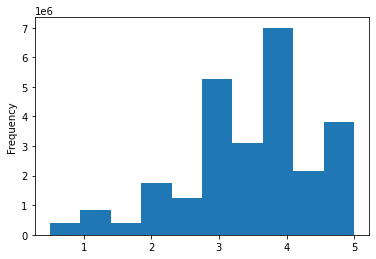

In [98]:
pd.options.display.float_format = '{:20,.2f}'.format
ratings['rating'].plot(kind='hist')
ratings['rating'].describe()

In [99]:
movies_df = pd.merge(wiki_movies_df, kaggle_metadata, on='imdb_id', suffixes=['_wiki','_kaggle'])

In [100]:
movies_df.columns



Index(['url', 'year', 'imdb_link', 'title_wiki', 'Based on', 'Starring',
       'Cinematography', 'Release date', 'Country', 'Language', 'Director',
       'Distributor', 'Editor(s)', 'Composer(s)', 'Producer(s)',
       'Production company(s)', 'Written by', 'imdb_id', 'box_office',
       'budget_wiki', 'release_date_wiki', 'running_time',
       'belongs_to_collection', 'budget_kaggle', 'genres', 'homepage', 'id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date_kaggle', 'revenue', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title_kaggle', 'video', 'vote_average',
       'vote_count'],
      dtype='object')

In [101]:
# Competing data:
# Wiki                     Movielens                Resolution
#--------------------------------------------------------------------------
# title_wiki               title_kaggle             Drop Wikipedia
# running_time             runtime                  Keep Kaggle; fill in zeros with Wikipedia data.
# budget_wiki              budget_kaggle            Keep Kaggle; fill in zeros with Wikipedia data.
# box_office               revenue                  Keep Kaggle; fill in zeros with Wikipedia data.
# release_date_wiki        release_date_kaggle
# Language                 original_language
# Production company(s)    production_companies

In [102]:
movies_df[['title_wiki','title_kaggle']]

,title_wiki,title_kaggle
0,The Adventures of Ford Fairlane,The Adventures of Ford Fairlane
1,"After Dark, My Sweet","After Dark, My Sweet"
2,Air America,Air America
3,Alice,Alice
4,Almost an Angel,Almost an Angel
...,...,...
6049,A Fantastic Woman,A Fantastic Woman
6050,Permission,Permission
6051,Loveless,Loveless
6052,Gemini,Gemini


In [103]:
movies_df[movies_df['title_wiki'] != movies_df['title_kaggle']][['title_wiki','title_kaggle']]

,title_wiki,title_kaggle
27,China Cry,China Cry: A True Story
36,Daddy's Dyin' ...Who's Got the Will?,Daddy's Dyin'... Who's Got the Will?
38,The Dark Side of the Moon,The Dark Side of The Moon
42,Delta Force 2,Delta Force 2: The Colombian Connection
48,DuckTales the Movie:Treasure of the Lost Lamp,DuckTales: The Movie - Treasure of the Lost Lamp
...,...,...
5958,Chips,CHiPS
5973,Spark,Spark: A Space Tail
5996,Pirates of the Caribbean:Dead Men Tell No Tales,Pirates of the Caribbean: Dead Men Tell No Tales
6025,Valerian and the Cityof a Thousand Planets,Valerian and the City of a Thousand Planets


In [104]:
# Show any rows where title_kaggle is empty
movies_df[(movies_df['title_kaggle'] == '') | (movies_df['title_kaggle'].isnull())]

,url,year,imdb_link,title_wiki,Based on,Starring,Cinematography,Release date,Country,Language,...,release_date_kaggle,revenue,runtime,spoken_languages,status,tagline,title_kaggle,video,vote_average,vote_count


<AxesSubplot:xlabel='running_time', ylabel='runtime'>

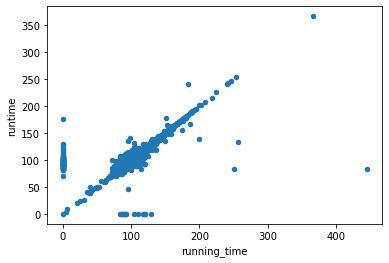

In [105]:
movies_df.fillna(0).plot(x='running_time', y='runtime', kind='scatter')

<AxesSubplot:xlabel='budget_wiki', ylabel='budget_kaggle'>

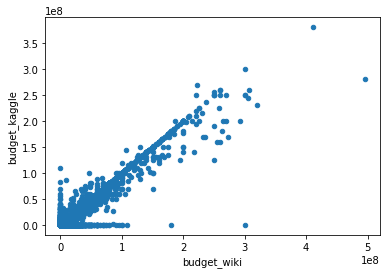

In [106]:
movies_df.fillna(0).plot(x='budget_wiki',y='budget_kaggle', kind='scatter')


<AxesSubplot:xlabel='box_office', ylabel='revenue'>

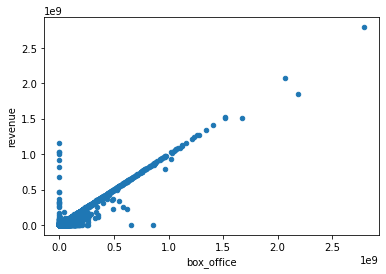

In [107]:
movies_df.fillna(0).plot(x='box_office', y='revenue', kind='scatter')

<AxesSubplot:xlabel='box_office', ylabel='revenue'>

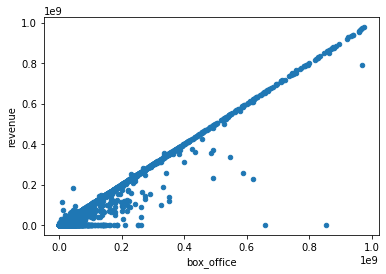

In [108]:
movies_df.fillna(0)[movies_df['box_office'] < 10**9].plot(x='box_office', y='revenue', kind='scatter')

<AxesSubplot:xlabel='release_date_wiki'>

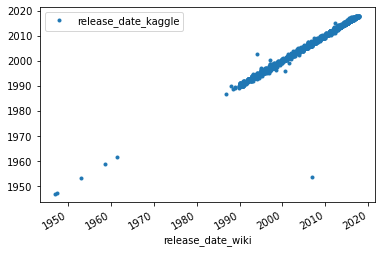

In [109]:
movies_df[['release_date_wiki','release_date_kaggle']].plot(x='release_date_wiki', y='release_date_kaggle', style='.')

In [110]:
movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')]

,url,year,imdb_link,title_wiki,Based on,Starring,Cinematography,Release date,Country,Language,...,release_date_kaggle,revenue,runtime,spoken_languages,status,tagline,title_kaggle,video,vote_average,vote_count
3609,https://en.wikipedia.org/wiki/The_Holiday,2006,https://www.imdb.com/title/tt00457939/,The Holiday,NaN,"[Kate Winslet, Cameron Diaz, Jude Law, Jack Bl...",Dean Cundey,"[December 8, 2006, (, 2006-12-08, )]",United States,English,...,1953-08-28,"30,500,000.00",118.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Pouring out of impassioned pages...brawling th...,From Here to Eternity,False,7.20,137.00


In [111]:
movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')].index

Int64Index([3609], dtype='int64')

In [112]:
movies_df = movies_df.drop(movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')].index)

In [113]:
movies_df[movies_df['release_date_wiki'].isnull()]

,url,year,imdb_link,title_wiki,Based on,Starring,Cinematography,Release date,Country,Language,...,release_date_kaggle,revenue,runtime,spoken_languages,status,tagline,title_kaggle,video,vote_average,vote_count
1010,https://en.wikipedia.org/wiki/Black_Scorpion_(...,1995,https://www.imdb.com/title/tt0112519/,Black Scorpion,NaN,"[Joan Severance, Bruce Abbott, Garrett Morris]",Geoff George,NaN,United States,NaN,...,1995-08-22,0.00,92.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Justice has a nasty sting.,Black Scorpion,False,6.10,7.00
1063,https://en.wikipedia.org/wiki/Flirt_(1995_film),1995,https://www.imdb.com/title/tt0113080/,Flirt,NaN,"[Bill Sage, Dwight Ewell, Miho Nikaido]",Michael Spiller,NaN,"[United States, Germany, Japan, [1]]",NaN,...,1995-09-14,0.00,85.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Flirt,False,7.50,4.00
1123,https://en.wikipedia.org/wiki/Let_It_Be_Me_(19...,1995,https://www.imdb.com/title/tt0113638/,Let It Be Me,NaN,NaN,Miroslav Ondrícek,NaN,NaN,NaN,...,1995-11-17,0.00,95.00,[],Released,NaN,Let It Be Me,False,8.00,2.00
1566,https://en.wikipedia.org/wiki/A_Brooklyn_State...,1997,https://www.imdb.com/title/tt0118782/,A Brooklyn State of Mind,NaN,NaN,Ken Kelsch,NaN,NaN,NaN,...,1998-01-01,0.00,89.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,A Brooklyn State of Mind,False,5.00,1.00
1635,https://en.wikipedia.org/wiki/Highball_(film),1997,https://www.imdb.com/title/tt0119291/,Highball,NaN,"[Justine Bateman, Peter Bogdanovich, Chris Eig...",Steven Bernstein,NaN,United States,English,...,1997-01-01,0.00,110.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Highball,False,4.50,4.00
1777,https://en.wikipedia.org/wiki/Velocity_Trap,1997,https://www.imdb.com/title/tt0120435/,Velocity Trap,NaN,"[Olivier Gruner, Alicia Coppola, Ken Olandt]",Philip D. Schwartz,NaN,United States,NaN,...,1999-02-22,0.00,86.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Crime at the Speed of Light,Velocity Trap,False,4.70,6.00
2388,https://en.wikipedia.org/wiki/The_Visit_(2000_...,2000,https://www.imdb.com/title/tt0199129/,The Visit,NaN,"[Hill Harper, Billy Dee Williams, Obba Babatun...",John L. Demps Jr.,NaN,NaN,English,...,2000-01-01,0.00,107.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Rumored,NaN,The Visit,False,0.00,0.00
2788,https://en.wikipedia.org/wiki/Stevie_(2002_film),2002,https://www.imdb.com/title/tt0334416/,Stevie,NaN,NaN,"[Dana Kupper, Gordon Quinn, Peter Gilbert]",NaN,United States,English,...,2002-09-09,"97,000.00",140.00,[],NaN,NaN,Stevie,False,6.70,13.00
3176,https://en.wikipedia.org/wiki/Return_to_Sender...,2004,https://www.imdb.com/title/tt0396190/,Return to Sender,NaN,"[Aidan Quinn, Connie Nielsen, Mark Holton]",NaN,NaN,"[Denmark, USA, UK]",NaN,...,2004-09-17,0.00,109.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"How can you save someone, who won't save herself?",Return to Sender,False,5.90,13.00
3653,https://en.wikipedia.org/wiki/Live_Free_or_Die...,2006,https://www.imdb.com/title/tt0432318/,Live Free or Die,NaN,"[Aaron Stanford, Paul Schneider, Ebon Moss-Bac...",NaN,NaN,United States,English,...,2006-03-11,0.00,89.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Live Free or Die,False,5.50,8.00


In [114]:
movies_df[movies_df['release_date_kaggle'].isnull()]

,url,year,imdb_link,title_wiki,Based on,Starring,Cinematography,Release date,Country,Language,...,release_date_kaggle,revenue,runtime,spoken_languages,status,tagline,title_kaggle,video,vote_average,vote_count


In [115]:
movies_df['Language'].apply(lambda x: tuple(x) if type(x) == list else x).value_counts(dropna=False)

English                                                                       5479
NaN                                                                            136
(English, Spanish)                                                              68
(English, French)                                                               35
(English, Japanese)                                                             25
                                                                              ... 
(English, Mandarin, Russian)                                                     1
(English, &, Serbo-Croatian)                                                     1
(English, German, Czech, Norwegian, Romanian, Russian, Serbian, Ukrainian)       1
(French, English, Persian, German)                                               1
(English, French, Arabic)                                                        1
Name: Language, Length: 198, dtype: int64

In [116]:
movies_df['original_language'].value_counts(dropna=False)

en    5989
fr      16
es      10
it       8
de       6
pt       4
zh       4
ja       4
hi       2
da       2
ar       1
cn       1
ko       1
tr       1
sv       1
ru       1
ab       1
he       1
Name: original_language, dtype: int64

In [117]:
movies_df[['Production company(s)','production_companies']]

,Production company(s),production_companies
0,Silver Pictures,[{'name': 'Twentieth Century Fox Film Corporat...
1,Avenue Pictures,"[{'name': 'Avenue Pictures Productions', 'id':..."
2,"[Carolco Pictures, IndieProd Company]","[{'name': 'IndieProd Company Productions', 'id..."
3,NaN,"[{'name': 'Orion Pictures', 'id': 41}]"
4,NaN,"[{'name': 'Paramount Pictures', 'id': 4}]"
...,...,...
6049,"[Fabula, Komplizen Film]","[{'name': 'Komplizen Film', 'id': 1618}, {'nam..."
6050,Ball & Chain Productions,"[{'name': 'Ball & Chain Productions', 'id': 74..."
6051,"[Arte France Cinéma, Why Not Productions]","[{'name': 'ARTE France Cinéma', 'id': 94}, {'n..."
6052,"[Film Science, Rough House Pictures, Syncopate...","[{'name': 'Film Science', 'id': 1976}, {'name'..."


In [118]:
# Competing data:
# Wiki                     Movielens                Resolution
#--------------------------------------------------------------------------
# title_wiki               title_kaggle             Drop Wikipedia
# running_time             runtime                  Keep Kaggle; fill in zeros with Wikipedia data.
# budget_wiki              budget_kaggle            Keep Kaggle; fill in zeros with Wikipedia data.
# box_office               revenue                  Keep Kaggle; fill in zeros with Wikipedia data.
# release_date_wiki        release_date_kaggle      Drop Wikipedia
# Language                 original_language        Drop Wikipedia
# Production company(s)    production_companies     Drop Wikipedia

In [119]:
movies_df.drop(columns=['title_wiki','release_date_wiki','Language','Production company(s)'], inplace=True)

In [120]:
def fill_missing_kaggle_data(df, kaggle_column, wiki_column):
    df[kaggle_column] = df.apply(
        lambda row: row[wiki_column] if row[kaggle_column] == 0 else row[kaggle_column]
        , axis=1)
    df.drop(columns=wiki_column, inplace=True)

In [121]:
fill_missing_kaggle_data(movies_df, 'runtime', 'running_time')
fill_missing_kaggle_data(movies_df, 'budget_kaggle', 'budget_wiki')
fill_missing_kaggle_data(movies_df, 'revenue', 'box_office')
movies_df

,url,year,imdb_link,Based on,Starring,Cinematography,Release date,Country,Director,Distributor,...,release_date_kaggle,revenue,runtime,spoken_languages,status,tagline,title_kaggle,video,vote_average,vote_count
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,"[July 11, 1990, (, 1990-07-11, )]",United States,Renny Harlin,20th Century Fox,...,1990-07-11,"20,423,389.00",104.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Kojak. Columbo. Dirty Harry. Wimps.,The Adventures of Ford Fairlane,False,6.20,72.00
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,"[May 17, 1990, (, 1990-05-17, ), (Cannes Film ...",United States,James Foley,Avenue Pictures,...,1990-08-24,"2,700,000.00",114.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,All they risked was everything.,"After Dark, My Sweet",False,6.50,17.00
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,"[August 10, 1990, (, 1990-08-10, )]",United States,Roger Spottiswoode,TriStar Pictures,...,1990-08-10,"33,461,269.00",112.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The few. The proud. The totally insane.,Air America,False,5.30,146.00
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,"[December 25, 1990, (, 1990-12-25, )]",United States,Woody Allen,Orion Pictures,...,1990-12-25,"7,331,647.00",102.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Alice,False,6.30,57.00
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,"December 19, 1990",US,John Cornell,Paramount Pictures,...,1990-12-21,"6,939,946.00",95.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Who does he think he is?,Almost an Angel,False,5.60,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6049,https://en.wikipedia.org/wiki/A_Fantastic_Woman,2018,https://www.imdb.com/title/tt5639354/,NaN,"[Daniela Vega, Francisco Reyes]",Benjamín Echazarreta,"[12 February 2017, (, 2017-02-12, ), (, Berlin...","[Chile, Germany, Spain, United States, [2]]",Sebastián Lelio,"[Participant Media (Chile), Piffl Medien (Germ...",...,2017-04-06,"3,700,000.00",104.00,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,NaN,A Fantastic Woman,False,7.20,13.00
6050,https://en.wikipedia.org/wiki/Permission_(film),2018,https://www.imdb.com/title/tt5390066/,NaN,"[Rebecca Hall, Dan Stevens, Morgan Spector, Fr...",Adam Bricker,"[April 22, 2017, (, 2017-04-22, ), (, Tribeca ...",United States,Brian Crano,Good Deed Entertainment,...,2017-04-22,NaN,96.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Permission,False,0.00,1.00
6051,https://en.wikipedia.org/wiki/Loveless_(film),2018,https://www.imdb.com/title/tt6304162/,NaN,"[Maryana Spivak, Aleksey Rozin, Matvey Novikov...",Mikhail Krichman,"[18 May 2017, (, 2017-05-18, ), (, Cannes, ), ...","[Russia, France, Belgium, Germany, [3]]",Andrey Zvyagintsev,"[Sony Pictures Releasing, (Russia), [1]]",...,2017-06-01,"4,800,000.00",128.00,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Loveless,False,7.80,26.00
6052,https://en.wikipedia.org/wiki/Gemini_(2017_film),2018,https://www.imdb.com/title/tt5795086/,NaN,"[Lola Kirke, Zoë Kravitz, Greta Lee, Michelle ...",Andrew Reed,"[March 12, 2017, (, 2017-03-12, ), (, SXSW, ),...",United States,Aaron Katz,Neon,...,2017-03-12,"200,340.00",92.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Post Production,NaN,Gemin

In [122]:
#Find any columns with only one value.
for col in movies_df.columns:
    lists_to_tuples = lambda x: tuple(x) if type(x) == list else x
    value_counts = movies_df[col].apply(lists_to_tuples).value_counts(dropna=False)
    num_values = len(value_counts)
    if num_values == 1:
        print(col)

video


In [123]:
#list comprehension instead of for loop.

In [124]:
movies_df['video'].value_counts(dropna=False)

False    6053
Name: video, dtype: int64

In [125]:
movies_df = movies_df.loc[:, ['imdb_id','id','title_kaggle','original_title','tagline','belongs_to_collection','url','imdb_link',
                       'runtime','budget_kaggle','revenue','release_date_kaggle','popularity','vote_average','vote_count',
                       'genres','original_language','overview','spoken_languages','Country',
                       'production_companies','production_countries','Distributor',
                       'Producer(s)','Director','Starring','Cinematography','Editor(s)','Written by','Composer(s)','Based on'
                      ]]

In [126]:
movies_df.rename({'id':'kaggle_id',
                  'title_kaggle':'title',
                  'url':'wikipedia_url',
                  'budget_kaggle':'budget',
                  'release_date_kaggle':'release_date',
                  'Country':'country',
                  'Distributor':'distributor',
                  'Producer(s)':'producers',
                  'Director':'director',
                  'Starring':'starring',
                  'Cinematography':'cinematography',
                  'Editor(s)':'editors',
                  'Written by':'writers',
                  'Composer(s)':'composers',
                  'Based on':'based_on'
                 }, axis='columns', inplace=True)

In [136]:
movies_df['kaggle_id']

0         9548
1        25501
2        11856
3         8217
4        25943
         ...  
6049    429191
6050    390059
6051    429174
6052    412302
6053    341689
Name: kaggle_id, Length: 6053, dtype: int64

In [149]:
rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count() \
                .rename({'userId':'count'}, axis=1) \
                .pivot(index='movieId',columns='rating', values='count')

In [150]:
rating_counts

rating,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50,5.00
movieId,,,,,,,,,,
1,441.00,804.00,438.00,"2,083.00","1,584.00","11,577.00","5,741.00","22,020.00","5,325.00","15,995.00"
2,263.00,797.00,525.00,"2,479.00","1,810.00","8,510.00","2,916.00","6,035.00",690.00,"2,035.00"
3,169.00,772.00,233.00,"1,665.00",616.00,"6,213.00",759.00,"3,433.00",154.00,"1,483.00"
4,47.00,351.00,31.00,496.00,77.00,"1,133.00",66.00,557.00,12.00,211.00
5,237.00,785.00,270.00,"1,716.00",664.00,"6,608.00",723.00,"2,959.00",166.00,"1,130.00"
...,...,...,...,...,...,...,...,...,...,...
176267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN
176269,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN
176271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00


In [151]:
rating_counts.columns = ['rating_' + str(col) for col in rating_counts.columns]

In [152]:
rating_counts

,rating_0.5,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5.0
movieId,,,,,,,,,,
1,441.00,804.00,438.00,"2,083.00","1,584.00","11,577.00","5,741.00","22,020.00","5,325.00","15,995.00"
2,263.00,797.00,525.00,"2,479.00","1,810.00","8,510.00","2,916.00","6,035.00",690.00,"2,035.00"
3,169.00,772.00,233.00,"1,665.00",616.00,"6,213.00",759.00,"3,433.00",154.00,"1,483.00"
4,47.00,351.00,31.00,496.00,77.00,"1,133.00",66.00,557.00,12.00,211.00
5,237.00,785.00,270.00,"1,716.00",664.00,"6,608.00",723.00,"2,959.00",166.00,"1,130.00"
...,...,...,...,...,...,...,...,...,...,...
176267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN
176269,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN
176271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00


In [153]:
movies_with_ratings_df = pd.merge(movies_df, rating_counts, left_on='kaggle_id', right_index=True, how='left')

In [154]:
movies_with_ratings_df[rating_counts.columns] = movies_with_ratings_df[rating_counts.columns].fillna(0)

In [157]:
movies_with_ratings_df.head()

,imdb_id,kaggle_id,title,original_title,tagline,belongs_to_collection,wikipedia_url,imdb_link,runtime,budget,...,rating_0.5,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5.0
0,tt0098987,9548,The Adventures of Ford Fairlane,The Adventures of Ford Fairlane,Kojak. Columbo. Dirty Harry. Wimps.,NaN,https://en.wikipedia.org/wiki/The_Adventures_o...,https://www.imdb.com/title/tt0098987/,104.00,"49,000,000.00",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,tt0098994,25501,"After Dark, My Sweet","After Dark, My Sweet",All they risked was everything.,NaN,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",https://www.imdb.com/title/tt0098994/,114.00,"6,000,000.00",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,tt0099005,11856,Air America,Air America,The few. The proud. The totally insane.,NaN,https://en.wikipedia.org/wiki/Air_America_(film),https://www.imdb.com/title/tt0099005/,112.00,"35,000,000.00",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,tt0099012,8217,Alice,Alice,NaN,NaN,https://en.wikipedia.org/wiki/Alice_(1990_film),https://www.imdb.com/title/tt0099012/,102.00,"12,000,000.00",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,tt0099018,25943,Almost an Angel,Almost an Angel,Who does he think he is?,NaN,https://en.wikipedia.org/wiki/Almost_an_Angel,https://www.imdb.com/title/tt0099018/,95.00,"25,000,000.00",...,3.00,0.00,3.00,2.00,5.00,26.00,37.00,46.00,16.00,11.00
